# Predicting Diabetes Using BRFSS Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import ADASYN
from collections import Counter

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('Diabetes_2022.csv')

In [4]:
y = df.Diabetes_01
X = df.drop(['Diabetes_01'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [6]:
print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

X_train: (228311, 24) X_test: (57078, 24)
y_train: (228311,) y_test: (57078,)


### ADASYN

In [7]:
adasyn = ADASYN(random_state=2)
X_adasyn_sampled, y_adasyn_sampled = adasyn.fit_resample(X_train, y_train)

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_adasyn_sampled)))


Original dataset shape Counter({0: 192339, 1: 35972})
Resampled dataset shape Counter({1: 193882, 0: 192339})


## Modeling

In [8]:
def optimize_model(model, param_grid, cv = 5, X_train = X_train, y_train = y_train):
    optimizer = GridSearchCV(model, param_grid = param_grid, scoring="accuracy", cv = cv, n_jobs = -1, verbose = True)
    optimizer.fit(X_train, y_train)
    print('Best parameters found:')
    print(optimizer.best_params_)
    print('\nBest score: %0.6f' % (optimizer.best_score_))
    
    return optimizer.best_estimator_

In [9]:
def evaluate_model(model, X_test = X_test, y_test = y_test):
    y_pred = model.predict(X_test)
    print('\nClassification report: ')
    print(classification_report(y_test, y_pred))

### Logistic Regression

In [10]:
lr_model = Pipeline([("scaler", StandardScaler()), ("model", LogisticRegression())])

lr_param_grid = {'model__C' : 10**np.arange(-3,4, dtype = float), 
                 'model__penalty' : ['l1','l2'],  
                 'model__class_weight' : ['balanced', None]}

In [11]:
lr_baseline = LogisticRegression(random_state = 0)
lr_baseline.fit(X_adasyn_sampled, y_adasyn_sampled)
print('Best score:', np.round(accuracy_score(y_test, lr_baseline.predict(X_test)), 6))
evaluate_model(lr_baseline)

Best score: 0.690283

Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.70      0.79     48163
           1       0.28      0.65      0.39      8915

    accuracy                           0.69     57078
   macro avg       0.60      0.67      0.59     57078
weighted avg       0.82      0.69      0.73     57078



In [12]:
lr_model = optimize_model(lr_model, lr_param_grid)
evaluate_model(lr_model)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best parameters found:
{'model__C': 0.001, 'model__class_weight': None, 'model__penalty': 'l2'}

Best score: 0.846950

Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     48163
           1       0.56      0.16      0.25      8915

    accuracy                           0.85     57078
   macro avg       0.71      0.57      0.58     57078
weighted avg       0.82      0.85      0.81     57078



In [13]:
lr_model = Pipeline([("scaler", StandardScaler()), ("model", LogisticRegression())])
lr_param_grid = {'model__C' : 10**np.linspace(-3, 0, num=50)}
lr_model = optimize_model(lr_model, lr_param_grid)
evaluate_model(lr_model)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:
{'model__C': 0.001}

Best score: 0.846950

Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     48163
           1       0.56      0.16      0.25      8915

    accuracy                           0.85     57078
   macro avg       0.71      0.57      0.58     57078
weighted avg       0.82      0.85      0.81     57078



<Figure size 200x100 with 0 Axes>

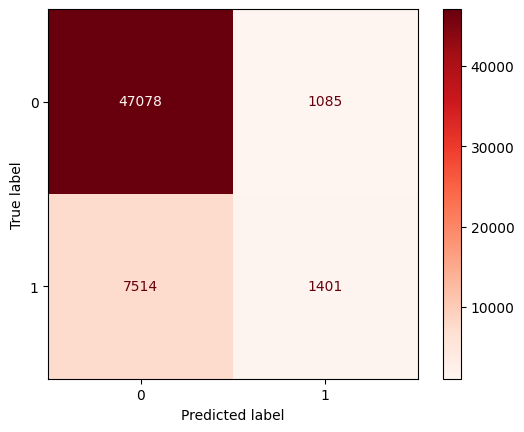

In [14]:
y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()


### Decision Tree Classifier

In [16]:
tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier())])

tree_param_grid = {'model__criterion': ['gini', 'entropy'],
                   'model__max_depth': [2, 5, 10, 20, 30],
                   'model__min_samples_leaf': [5, 10, 20, 30]}

In [17]:
tree_baseline = DecisionTreeClassifier(random_state = 0)
tree_baseline.fit(X_adasyn_sampled, y_adasyn_sampled)
print('Best score:', np.round(accuracy_score(y_test, tree_baseline.predict(X_test)), 6))
evaluate_model(tree_baseline)

Best score: 0.705964

Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.76      0.81     48163
           1       0.25      0.43      0.31      8915

    accuracy                           0.71     57078
   macro avg       0.56      0.59      0.56     57078
weighted avg       0.78      0.71      0.73     57078



In [18]:
tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found:
{'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 30}

Best score: 0.846486

Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     48163
           1       0.56      0.12      0.20      8915

    accuracy                           0.85     57078
   macro avg       0.71      0.55      0.56     57078
weighted avg       0.81      0.85      0.80     57078



In [19]:
tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier(criterion = 'entropy', 
                                                                                      max_depth = 10))])
tree_param_grid = {'model__min_samples_leaf': [30, 45, 50, 75, 100, 150, 200, 300, 500, 650, 750, 900]}
tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:
{'model__min_samples_leaf': 650}

Best score: 0.848001

Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     48163
           1       0.58      0.11      0.19      8915

    accuracy                           0.85     57078
   macro avg       0.72      0.55      0.55     57078
weighted avg       0.81      0.85      0.80     57078



Narrowing down the area

In [20]:
tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier(criterion = 'entropy', 
                                                                                      max_depth = 10))])
tree_param_grid = {'model__min_samples_leaf': np.arange(630,650,1)}
tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:
{'model__min_samples_leaf': 645}

Best score: 0.848001

Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     48163
           1       0.58      0.11      0.19      8915

    accuracy                           0.85     57078
   macro avg       0.72      0.55      0.55     57078
weighted avg       0.81      0.85      0.80     57078



<Figure size 200x100 with 0 Axes>

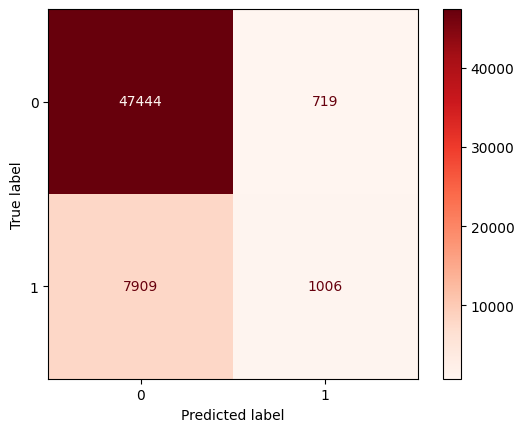

In [21]:
y_pred = tree_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

### XGBoost Classifier

In [22]:
xgb_classifier = xgb.XGBClassifier(eval_metric='error', random_state = 0)
xgb_classifier.fit(X_adasyn_sampled, y_adasyn_sampled)
print('Best score:', np.round(accuracy_score(y_test, xgb_classifier.predict(X_test)), 6))
evaluate_model(xgb_classifier)

Best score: 0.692123

Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.70      0.79     48163
           1       0.28      0.63      0.39      8915

    accuracy                           0.69     57078
   macro avg       0.60      0.67      0.59     57078
weighted avg       0.81      0.69      0.73     57078



<Figure size 200x100 with 0 Axes>

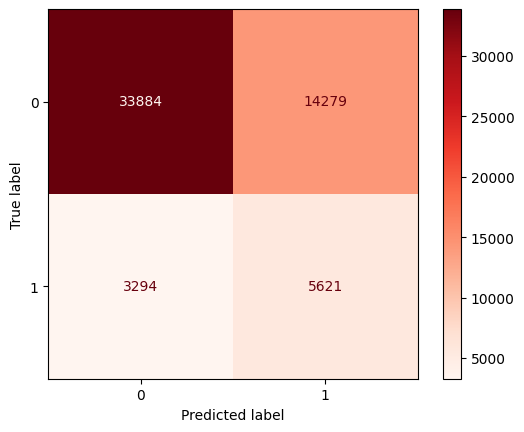

In [23]:
y_pred = xgb_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

## Metrics

In [24]:
from sklearn import metrics
model_name = []
accuracy_score = []
f1_score = []
roc_auc_score = []
recall_score = []
precision_score = []
    
def metrics_models(name, model, X_test = X_test, y_test = y_test):
    models = list()
    models.append((name, model))
    
    for name, model in models:
        model_name.append(name)
        accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
        f1_score.append(metrics.f1_score(y_test, model.predict(X_test)))
        roc_auc_score.append(metrics.roc_auc_score(y_test, model.predict(X_test)))
        recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
        precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))


In [25]:
metrics_models('Base LinearRegression (Adasyn Oversample)', lr_baseline)
metrics_models('LinearRegression (Adasyn Oversample)', lr_model)
metrics_models('Base DecisionTreeClassifier (Adasyn Oversample)', tree_baseline)
metrics_models('DecisionTreeClassifier (Adasyn Oversample)', tree_model)
metrics_models('XGBoostClassifier (Adasyn Oversample)', xgb_classifier)

In [26]:
metric_df_adasyn = pd.DataFrame({'Model': model_name,
                           'Accuracy': accuracy_score,
                           'F1-score': f1_score,
                           'AUC': roc_auc_score,
                           'Recall': recall_score,
                           'Precision': precision_score})

In [27]:
metric_df_adasyn

,Model,Accuracy,F1-score,AUC,Recall,Precision
0,Base LinearRegression (Adasyn Oversample),0.690283,0.394713,0.672465,0.646551,0.284067
1,LinearRegression (Adasyn Oversample),0.849347,0.245768,0.567312,0.157151,0.563556
2,Base DecisionTreeClassifier (Adasyn Oversample),0.705964,0.313045,0.593091,0.428940,0.246455
3,DecisionTreeClassifier (Adasyn Oversample),0.848838,0.189098,0.548958,0.112844,0.583188
4,XGBoostClassifier (Adasyn Oversample),0.692123,0.390144,0.667019,0.630510,0.282462
